<h1><center> ComS 573     </center></h1>
<h1><center> Lab 2 </center></h1>
<h1><center> Kanak Choudhury </center></h1>

# Problem 2

For this problem, I have used the following parameter combinations
    
    hid_layer = [2,3]
    num_epochs = [80, 100, 120]
    btch_size = [128, 200]
    learning_rate = [0.05, 0.1, 0.2]
    momentum = [.5, 0.9, 1]
    los = ['categorical_crossentropy']
    scale = ['Standardize', 'Normalize']
    activ = ['relu']
    filters = [64, 32]
    kernel_size = [(3,3), (4, 4)]

Also used 80% - 20% training - validation data.

In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib
import keras
import re
import sys
import gc
import time

print('python ' +sys.version)
print('numpy '+ np.__version__)
print('pandas '+ pd.__version__)
print('sklearn '+ sklearn.__version__)
print('matplotlib '+ matplotlib.__version__)
print('keras '+ keras.__version__)
print('re '+ re.__version__)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from itertools import product

Using TensorFlow backend.


python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
matplotlib 3.1.3
keras 2.3.1
re 2.2.1


In [2]:
path  = 'D:/ISU/COMS 573 - Machine Learning/HW/Lab2/'

train_model = False

df_tr = pd.read_csv(path+'optdigits.tra',header=None)
X_tr, y_tr = df_tr.loc[:,0:63], df_tr.loc[:,64]
ccat = y_tr.unique().size

df_ts = pd.read_csv(path+'optdigits.tes',header=None)
X_ts,  y_ts  = df_ts.loc[:,0:63],  df_ts.loc[:,64]

scaler = StandardScaler().fit(X_tr)
normalizer = Normalizer().fit(X_tr)

X_tr_std = scaler.transform(X_tr)
X_tr_norm = normalizer.transform(X_tr)


split = 0.8
size = np.shape(X_tr)
nsplit = int(np.floor(split*size[0]))

y_train1 = np_utils.to_categorical(y_tr, ccat)
y_train = y_train1[0:nsplit,:];
y_val = y_train1[nsplit:size[0],:];
y_test = np_utils.to_categorical(y_ts, ccat)


X_train_std = X_tr_std[0:nsplit,:];
X_val_std = X_tr_std[nsplit:size[0],:];
X_test_std = scaler.transform(X_ts)

X_train_std = X_train_std.reshape(-1, 8, 8, 1)
X_val_std = X_val_std.reshape(-1, 8, 8, 1)
X_test_std = X_test_std.reshape(-1, 8, 8, 1)



X_train_norm = X_tr_norm[0:nsplit,:];
X_val_norm = X_tr_norm[nsplit:size[0],:];
X_test_norm = normalizer.transform(X_ts)

X_train_norm = X_train_norm.reshape(-1, 8, 8, 1)
X_val_norm = X_val_norm.reshape(-1, 8, 8, 1)
X_test_norm = X_test_norm.reshape(-1, 8, 8, 1)

In [3]:
if train_model: 
    hid_layer = [2,3]
    num_epochs = [80, 100, 120]
    btch_size = [128, 200]
    learning_rate = [0.05, 0.1, 0.2]
    momentum = [.5, 0.9, 1]
    los = ['categorical_crossentropy']
    scale = ['Standardize', 'Normalize']
    activ = ['relu']
    filters = [64, 32]
    kernel_size = [(3,3), (4, 4)]


    def expand_grid(dictionary):
       return pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())

    dictionary = {'hidden_layers': hid_layer,
                  'filters': filters,
                  'num_epochs': num_epochs, 
                  'batch_size': btch_size,
                  'learning_rate': learning_rate,
                  'momentum': momentum,
                  'loss_func': los,
                  'data_scaling': scale,
                  'activation_func': activ,
                  'kernel_size': kernel_size}

    prem1 = expand_grid(dictionary)
    prem1 = prem1[~((prem1['activation_func'] == 'tanh') & (prem1['loss_func'] == 'mean_squared_error'))]
    prem1['time'] = np.NaN
    prem1['train_loss'] = np.NaN
    prem1['validation_loss'] = np.NaN
    prem1['test_loss'] = np.NaN
    prem1['train_acc'] = np.NaN
    prem1['validation_acc'] = np.NaN
    prem1['test_acc'] = np.NaN
    size_prem1 = prem1.shape
    print(prem1.head())
    
    ll = 0 
    for j in range(0,2):
        if j == 0:
            X_train = X_train_std
            X_val = X_val_std
            X_test = X_test_std
            listind = prem1[prem1['data_scaling'] == 'Standardize'].index.tolist()
        else:
            X_train = X_train_norm
            X_val = X_val_norm
            X_test = X_test_norm
            listind = prem1[prem1['data_scaling'] == 'Normalize'].index.tolist()

        for i in listind:
            try:
                start = time. time()
                if prem1.iloc[i,0] == 1:
                    model = Sequential()
                    model.add(Convolution2D(filters = 64, kernel_size= prem1.iloc[i,9], 
                                            input_shape=(8,8,1), activation='relu', padding='valid')) 
                    model.add(MaxPooling2D(pool_size=(2,2), padding='valid')) 
                    model.add(Dropout(0.3))
                    model.add(Flatten())
                    model.add(Dense(10, activation='softmax'))

                elif prem1.iloc[i,0] == 2:
                    model = Sequential()
                    model.add(Convolution2D(filters = 64, kernel_size= prem1.iloc[i,9], 
                                            input_shape=(8,8,1), activation='relu', padding='valid')) 
                    model.add(Convolution2D(filters = prem1.iloc[i,1], kernel_size= prem1.iloc[i,9], padding='valid'))
                    model.add(MaxPooling2D(pool_size=(2,2), padding='valid')) 
                    model.add(Dropout(0.3))
                    model.add(Flatten())
                    model.add(Dense(10, activation='softmax'))

                else:
                    model = Sequential()            
                    model.add(Convolution2D(filters = 64, kernel_size= prem1.iloc[i,9], 
                                            input_shape=(8,8,1), activation='relu', padding='valid')) 
                    model.add(Convolution2D(filters = prem1.iloc[i,1], kernel_size= prem1.iloc[i,9], padding='valid'))
                    model.add(Convolution2D(filters = prem1.iloc[i,1], kernel_size= prem1.iloc[i,9], padding='valid'))
                    model.add(MaxPooling2D(pool_size=(2,2), padding='valid')) 
                    model.add(Dropout(0.3))
                    model.add(Flatten())
                    model.add(Dense(10, activation='softmax'))


                es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=200)
                mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


                optimizer1 = optimizers.SGD(lr=prem1.iloc[i,4], momentum=prem1.iloc[i,5])
                model.compile(optimizer=optimizer1, loss=prem1.iloc[i,6], metrics=['accuracy'])
                fit1 = model.fit(X_train,y_train, batch_size=prem1.iloc[i,3], epochs=prem1.iloc[i,2], 
                                 validation_data=(X_val,y_val), callbacks=[es, mc], verbose = 0)
                fit = load_model('best_model')
                end = time.time()
                train_accuracy = fit.evaluate(X_train, y_train, verbose=0)
                val_accuracy = fit.evaluate(X_val, y_val, verbose=0)
                test_accuracy = fit.evaluate(X_test, y_test, verbose=0)
                prem1.iloc[i, 10:17] = [end-start, train_accuracy[0], val_accuracy[0], test_accuracy[0], 
                                      train_accuracy[1], val_accuracy[1], test_accuracy[1]]


                del model, es, mc, optimizer1, fit, fit1
                gc.collect()
            except:
                pass
            finally:
                ll = ll+1
                sys.stdout.write("\r Progress: %.2f%%" %round(float(ll)/size_prem1[0]*100,2))
                sys.stdout.flush()
else:
    print('skiped model fit')

skiped model fit



 Best 10 hyper-parameter combination for Cross-Entropy:
      hidden_layers  filters  num_epochs  batch_size  learning_rate  momentum  \
509              3       64         100         128           0.20       0.5   
487              3       64          80         128           0.05       0.9   
521              3       64         120         128           0.05       0.9   
579              3       32         120         200           0.10       0.5   
580              3       32         120         200           0.10       0.9   
547              3       32          80         200           0.10       0.5   
556              3       32         100         128           0.10       0.5   
332              2       64         100         200           0.10       0.9   
355              2       64         120         128           0.20       0.5   
374              2       64         120         200           0.20       0.9   

                    loss_func data_scaling activation_func ke

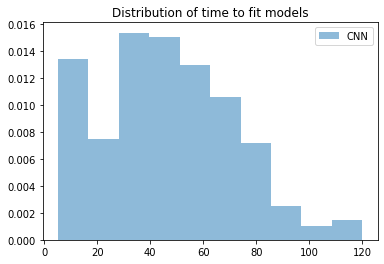

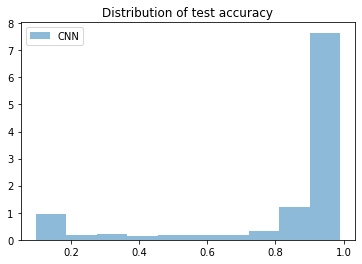

In [4]:
if train_model:
    prem1.to_csv (path+'res_2.csv', index = False, header=True)
    prem = prem1
else:
    prem = pd.read_csv(path+'res_2.csv',header=0)
    prem.head()

    kk1 = []
    for i in range(prem.shape[0]):
        kk1.append(tuple(map(int, prem.iloc[i,9].replace('(', '').replace(')', '').replace(' ', '').split(','))))
    prem['kernel_size'] = kk1

top10_cce = prem[prem['loss_func'] == 'categorical_crossentropy'].nlargest(10,'test_acc')
print('\n Best 10 hyper-parameter combination for Cross-Entropy:\n', round(top10_cce, 4))


plt.hist(prem.iloc[:,10],  density=True, alpha=0.5, label=['CNN'])
plt.legend(loc='upper right')
plt.title('Distribution of time to fit models')
# plt.xlim(0, 200)
plt.show()

plt.hist(prem.iloc[:,16],
         density=True, alpha=0.5, label=['CNN'])
plt.legend(loc='upper left')
plt.title('Distribution of test accuracy')
plt.show()

In [5]:
aaa = prem.iloc[:,10]
print("Mean and Variance of fitted time:\n CNN: Mean = %.2f, \
var = %.2f\n" %(np.mean(aaa), np.var(aaa)))

aaa = prem.iloc[:,16]
print("Mean and Variance of test accuracy:\n CNN: Mean = %.4f, \
var = %.4f\n" %(np.mean(aaa), np.var(aaa)))

Mean and Variance of fitted time:
 CNN: Mean = 46.11, var = 655.43

Mean and Variance of test accuracy:
 CNN: Mean = 0.8302, var = 0.0736



In [6]:
top10 = top10_cce
print("\n Results For CNN")
print("******************************************\n")


if top10.iloc[0,7] == 'Standardize':
    X_train = X_train_std
    X_val = X_val_std
    X_test = X_test_std
else:
    X_train = X_train_norm
    X_val = X_val_norm
    X_test = X_test_norm


start = time. time()
if top10.iloc[0,0] == 1:
    model = Sequential()
    model.add(Convolution2D(filters = 64, kernel_size= top10.iloc[0,9], 
                            input_shape=(8,8,1), activation='relu', padding='valid')) 
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid')) 
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

elif top10.iloc[0,0] == 2:
    model = Sequential()
    model.add(Convolution2D(filters = 64, kernel_size= top10.iloc[0,9], 
                            input_shape=(8,8,1), activation='relu', padding='valid')) 
    model.add(Convolution2D(filters = top10.iloc[0,1], kernel_size= top10.iloc[0,9], padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid')) 
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

else:
    model = Sequential()            
    model.add(Convolution2D(filters = 64, kernel_size= top10.iloc[0,9], 
                            input_shape=(8,8,1), activation='relu', padding='valid')) 
    model.add(Convolution2D(filters = top10.iloc[0,1], kernel_size= top10.iloc[0,9], padding='valid'))
    model.add(Convolution2D(filters = top10.iloc[0,1], kernel_size= top10.iloc[0,9], padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid')) 
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))


es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=200)
mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


optimizer1 = optimizers.SGD(lr=top10.iloc[0,4], momentum=top10.iloc[0,5])
model.compile(optimizer=optimizer1, loss=top10.iloc[0,6], metrics=['accuracy'])
fit1 = model.fit(X_train,y_train, batch_size=top10.iloc[0,3], epochs=top10.iloc[0,2], 
                 validation_data=(X_val,y_val), callbacks=[es, mc], verbose = 0)
fit = load_model('best_model')
end = time.time()
train_accuracy = fit.evaluate(X_train, y_train, verbose=0)
val_accuracy = fit.evaluate(X_val, y_val, verbose=0)
test_accuracy = fit.evaluate(X_test, y_test, verbose=0)
final_res = [end-start, train_accuracy[0], val_accuracy[0], test_accuracy[0], 
                      train_accuracy[1], val_accuracy[1], test_accuracy[1]]

if top10.iloc[0,7] == 'Standardize':
    X_train11 = X_tr_std.reshape(-1, 8, 8, 1)
    X_test = X_test_std
    y_train11 = y_train1
else:
    X_train11 = X_tr_norm.reshape(-1, 8, 8, 1)
    X_test = X_test_norm
    y_train11 = y_train1

print("For hyper-parameters:\n",top10.iloc[0,:])
print("\n Time needed: %.2f" % (end-start))
scores = fit.evaluate(X_test, y_test, verbose=0)
print("\n Test Accuracy: %.2f%%" % (scores[1]*100))

A = fit.predict(X_train11)
cm = confusion_matrix(y_train11.argmax(axis=1), A.argmax(axis=1))
print("\n Train confusion matrix: \n", cm)
acc_train = np.diagonal(cm)/cm.sum(axis=1)
print("\n Class Accuracy for Training Data is:")
for i in range(10):
    print('Class %d: %.2f%%' %(i, acc_train[i]*100))

A = fit.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), A.argmax(axis=1))
print("\n Test confusion matrix: \n", cm)
acc_test = np.diagonal(cm)/cm.sum(axis=1)
print("\n Class Accuracy for Testing Data is:")
for i in range(10):
    print('Class %d: %.2f%%' %(i, acc_test[i]*100))
print("**********************************\n")


 Results For CNN
******************************************

For hyper-parameters:
 hidden_layers                             3
filters                                  64
num_epochs                              100
batch_size                              128
learning_rate                           0.2
momentum                                0.5
loss_func          categorical_crossentropy
data_scaling                    Standardize
activation_func                        relu
kernel_size                          (3, 3)
time                                104.516
train_loss                      3.74972e-05
validation_loss                   0.0481159
test_loss                         0.0407299
train_acc                                 1
validation_acc                     0.992157
test_acc                           0.989983
Name: 509, dtype: object

 Time needed: 67.97

 Test Accuracy: 98.55%

 Train confusion matrix: 
 [[376   0   0   0   0   0   0   0   0   0]
 [  0 389   0   0   0   0 

Based on the time distribution, CNN takes longer time than fully connected feed-forward networks. However, the time distribution for CNN is less skewed than fully connected feed-forward networks. 

Based on test accuracy distributions, overall accuracy for test data using CNN is higher (about 98%) than the fully connected feed-forward networks and the variance is also lower for these hyper-parameter combinations.

It is found that using CNN with 3 hidden layers, 64 units, number of epochs 100, batch size 128, learning rate 0.2, momentum 0.5 and kernel size (3,3) has the highest test accuracy (about 98.00%) which is higher than the fully connected feed forward networks. Note that, this model was fitted based on only 1-fold cross validation with no repeated sample. It might be different if we use repeated $k$ fold cross validation.

Training accuracy for all classes are almost 100%. However, test accuracy for all classes are around 98%. Class 0 and 1 have the highest test accuracy (about 100%) and class 8 has the lowest accuracy (about 97%) which is much higher than the fully connected feed forward networks. Overall classiﬁcation accuracy, class accuracy, and confusion matrix for both training and testing data are given in above tables.

## Important References:

1. https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5

2. https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37

3. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

4. https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

5. https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca